In [1]:
from sel import selectiveSearch
from dataload import voc
import numpy as np
import cv2
import pickle
from PIL import Image
from utils import getIoU
from nms import nms_detections

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from f_new import *
import tqdm
import matplotlib.pylab as plt

1.0


In [14]:
classes = [
    "__background__",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]


## GET PREDICTION
 get the predicted class of an image using cnn features and svm 
returns the class id and the prediction probability

In [15]:
loaded_model = pickle.load(open('svmmodel_pascalvoc_alexnet_noft_prob.sav', 'rb'))

def getPred(im):
    """
    return predicted class of the image and score
    """
    f = featureExtractor(im).cpu().data.numpy()
    result = int(loaded_model.predict(f)[0])
    cls_score  = loaded_model.predict_proba(f)[0][result - 1]
    return result, cls_score


## getRes()
+ runs selective search on the image
+ for each bbox get the predicted class and score
+ bins the bboxs based on the class
+ applies non max supression to remove overlaping bboxs
+ returns the bbox and the corresponding classes

In [27]:
def pplot(im,ss,title="", l = None):
    im2 = im.copy()
    for i,rect in enumerate(ss):
        x, y, w, h = rect
        cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
        if l is not None:
            cv2.putText(im2, classes[l[i]], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (36,255,12), 1)
    plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
    
def getRes(im):
    ss = selectiveSearch(im)
    pplot(im,ss,"selective search")
    H,W,_ = im.shape
    bbox = []
    cls = []
    bbox_class = []
    bbox_score = []
    bboxtmp = []
    for i in range(21):
        bbox_class.append([])
        bbox_score.append([])
    if len(ss) > 2000:
        ss = ss[:2000]
    for e, result in tqdm.tqdm(enumerate(ss)):
        x, y, w, h = result
        if w*h/H*W < 0.007:
            continue
        imcut = im[y : y + h, x : x + w]
        img = cv2.cvtColor(imcut, cv2.COLOR_BGR2RGB) 
        img =  Image.fromarray(img)
        cl, sc = getPred(img)
        if sc < 0.9 or cl == 20:
            continue
        bbox_class[cl].append(result)
        bbox_score[cl].append(sc)
        bboxtmp.append(result)
    pplot(im,bboxtmp,"after score aggro")
    for i,bboxs in enumerate(bbox_class):
        if bboxs != [] and i != 0:
            picks = nms_detections(bboxs, bbox_score[i])
            bbs = np.array(bboxs)
            bbs = bbs[picks]
            for bb in bbs:
                bbox.append(bb)
                cls.append(i)
    
    print(len(bbox))
    return {"bbox": bbox, "class": cls}



In [20]:
def getScore(gr, out, thresh=0.5):
    outClass = out["class"]
    outbbox = out["class"]
    groundbbox = gr["class"]
    groundClass = gr["class"]
    score = 0
    counter = 0
    for i, cls in enumerate(outClass):
        for j, gcls in enumerate(groundClass):
            if cls != gCls:
                continue
            iou = getIoU(outbbox[i], groundbbox[j])
            if iou > thresh:
                score += 1
                break
        counter += 1
    return score, counter



007721.xml


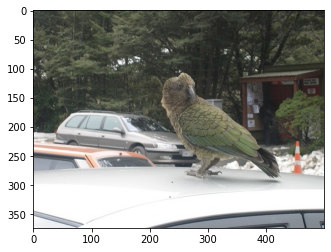

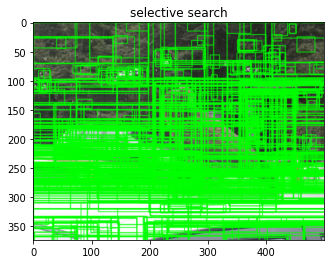

1221it [01:58, 10.26it/s]


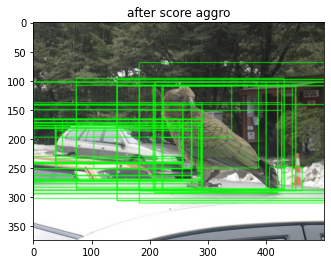

3


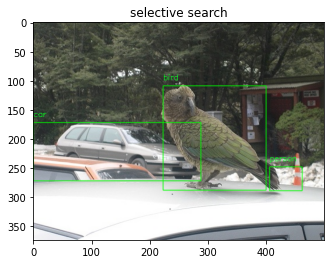

[3, 7, 15]


In [28]:
if __name__ == "__main__":
    trainPath = "VOC2007"
    obj = voc(trainPath)
    positive = 0
    counter = 0
    maxFiles = 100
    
    o = obj[33]
    pplot(o["im"],[])
    res = getRes(o["im"])
    gCls = o["class"]
    cls = res["class"]

    pplot(o["im"],res["bbox"],"selective search",cls)
    print(cls)

005467.xml


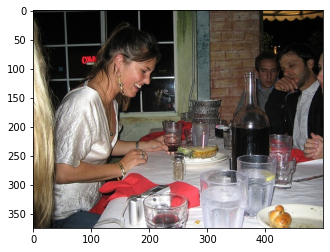

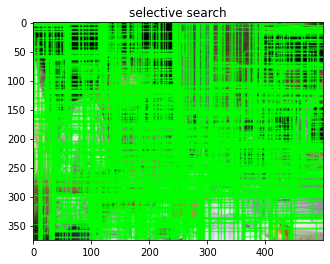

2000it [03:15, 10.21it/s]


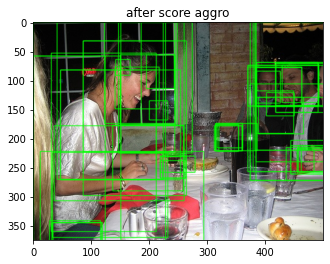

10


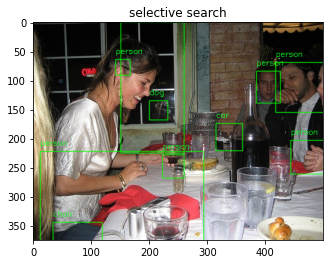

[7, 9, 12, 15, 15, 15, 15, 15, 15, 15]


In [30]:

trainPath = "VOC2007"
obj = voc(trainPath)
positive = 0
counter = 0
maxFiles = 100

o = obj[34]
pplot(o["im"],[])
res = getRes(o["im"])
gCls = o["class"]
cls = res["class"]

pplot(o["im"],res["bbox"],"selective search",cls)
print(cls)

003642.xml


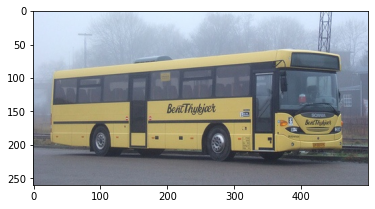

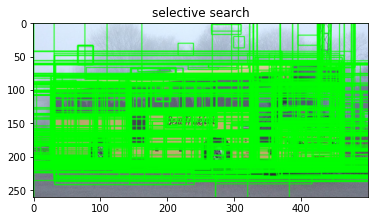

971it [01:34, 10.23it/s]


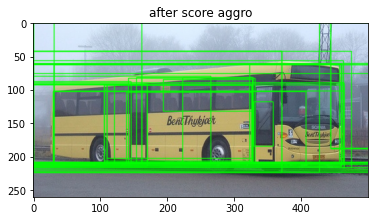

4


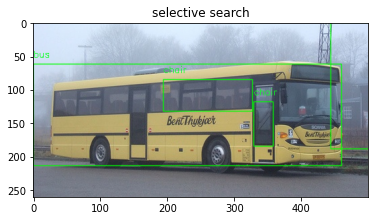

[6, 9, 9, 9]


In [31]:

trainPath = "VOC2007"
obj = voc(trainPath)
positive = 0
counter = 0
maxFiles = 100

o = obj[35]
pplot(o["im"],[])
res = getRes(o["im"])
gCls = o["class"]
cls = res["class"]

pplot(o["im"],res["bbox"],"selective search",cls)
print(cls)